# Read NYC orthoimagery and Land Cover labels using Raster Vision

* The imagery comes from the [2016 Manhattan Orthoimagery](https://data.cityofnewyork.us/City-Government/2016-Orthoimagery-Manhattan/xuek-2su9) (there is also imagery available for other boroughs). It is RGB-IR and is in JP2 format.
* This does not use the [DEM raster dataset](https://data.cityofnewyork.us/City-Government/Topobathymetric-LiDAR-Data-2017-/7sc8-jtbz
) derived from Lidar which was used to create the land cover map.
* The labels come from [2017 Land Cover raster](https://data.cityofnewyork.us/Environment/Land-Cover-Raster-Data-2017-6in-Resolution/he6d-2qns) which covers the entire city. The data is formatted as HFA/Erdas Imagine Images (.img).
* More information about these datasets along with a map-based visualization can be found [here](https://maps.nyc.gov/lidar/2017/).
* This uses Raster Vision 0.20.2

In [2]:
from os.path import join

from rastervision.core.data import (
    RasterioSource, ClassConfig, SemanticSegmentationLabelSource, 
    RasterioCRSTransformer, RasterioSource, Scene)
from rastervision.pytorch_learner.dataset import (
    SemanticSegmentationSlidingWindowGeoDataset)
from rastervision.pytorch_learner.dataset.visualizer import (
    SemanticSegmentationVisualizer)


In [12]:
# (1) Tree Canopy, (2) Grass\Shrubs, (3) Bare Soil, (4) Water, (5) Buildings, (6) Roads, (7) Other Impervious, and (8) Railroads
class_config = ClassConfig(
    names=['Background', 'Tree Canopy', 'Grass-Shrubs', 'Bare Soil', 'Water', 'Buildings', 'Roads', 'Other Impervious', 'Railroads'],
    colors=['orange', 'green', 'yellowgreen', 'saddlebrown', 'blue', 'red', 'black', 'grey', 'purple'],
    null_class='Background')

# A single 5000x5000 pixel image
img_path = '/Users/lewfish/Downloads/2018_Manhattan_Orthoimagery_jp2/002235.jp2'
# The labels for all of NYC
label_path = '/Users/lewfish/Downloads/Land_Cover/NYC_2017_LiDAR_LandCover.img'

In [13]:
# Correct for the fact that the labels have a different extent than the imagery which 
# RV does not handle automatically.
rs_img = RasterioSource(img_path)
crs_tf_img = rs_img.crs_transformer
crs_tf_label = RasterioCRSTransformer.from_uri(label_path)
extent_pixel_img = rs_img.extent
extent_map = crs_tf_img.pixel_to_map(extent_pixel_img)
extent_pixel_label = crs_tf_label.map_to_pixel(extent_map)
rs_label = RasterioSource(label_path, extent=extent_pixel_label)

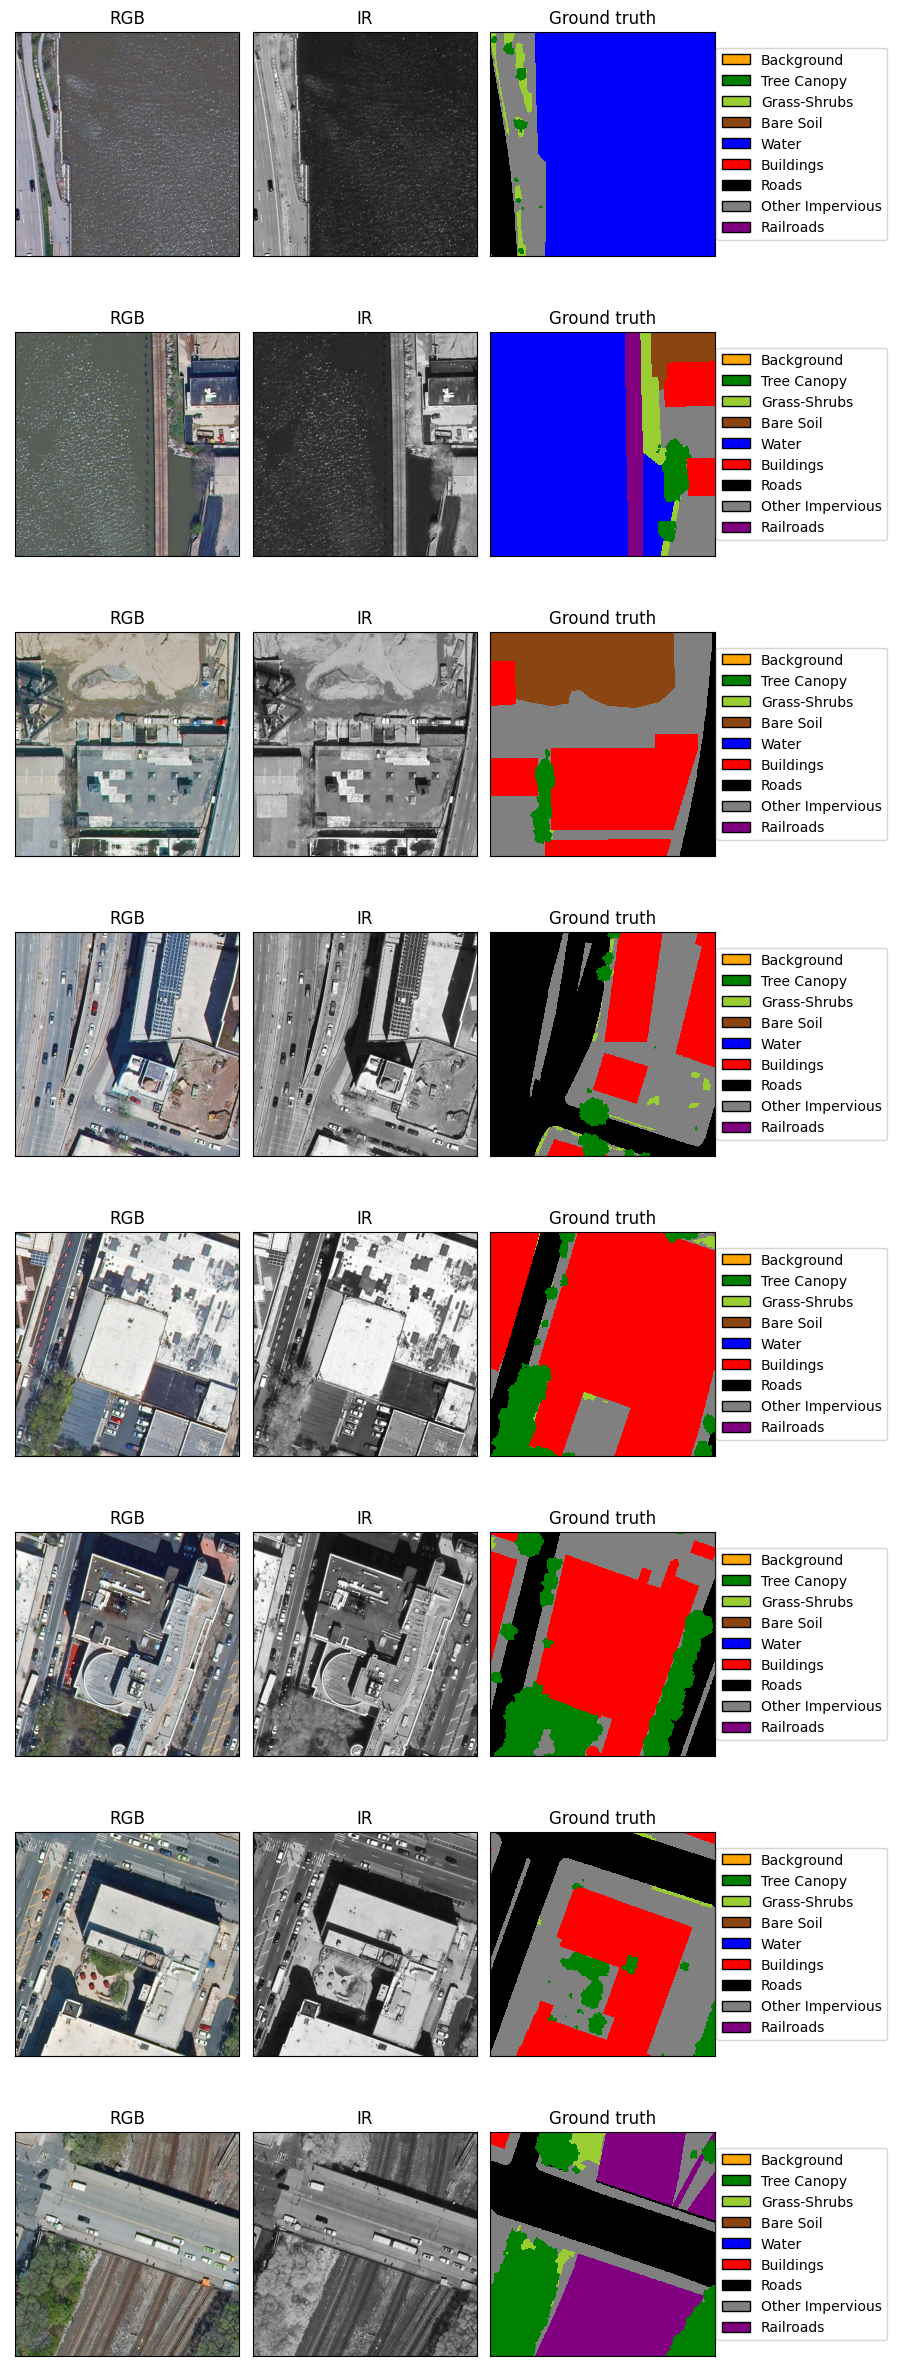

In [14]:
channel_display_groups = {'RGB': (0, 1, 2), 'IR': (3, )}

scene = Scene(
    id='my_scene',
    raster_source=rs_img,
    label_source=SemanticSegmentationLabelSource(rs_label, class_config))
ds = SemanticSegmentationSlidingWindowGeoDataset(
    scene, size=600, stride=600)

vis = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors,
    channel_display_groups=channel_display_groups)
x, y = vis.get_batch(ds, 8)
vis.plot_batch(x, y, show=True)